<a href="https://colab.research.google.com/github/rcs-science-research/Dendritic-Branching-GSEA/blob/main/Dendritic_Branching_Associated_Pathways_GSEA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Identifying Gene Sets Associated with Dendritic Branching using Gene Set Enrichment Analysis (GSEA)


Neuronal function and connectivity are heavily influenced by the structure and complexity of dendrites, branching extensions that integrate signals from other neurons. Dendritic arborization, the process by which dendrites form and develop, is crucial for the proper function of individual neurons and the brain (McAllister, 2005). Local and cell-wide dendrite patterning are regulated by neuronal activity, with calcium influx mediated by ion channels like NMDA (N-methyl-D-aspartate) receptors and VSCCs (voltage-sensitive calcium channels) (Wong & Ghosh, 2002). Calcium signaling has been shown to regulate local dendrite structure, affecting branch dynamics and stability (Konur & Ghosh, 2005), and activate intracellular signaling proteins, such as CaMKs (calmodulin-dependent protein kinases), which modulate gene expression (Redmond et al., 2002). Still, the molecular mechanisms and underlying dendritic arborization remain to be fully understood, and are critical for understanding neural circuit development and synaptic connectivity, as well as various neurological pathologies.

In this notebook, we will examine the regulation of dendritic morphology through analysis of the transcriptomic and morphological cortical mouse neuron data provided by the Allen Institute (Gouwens et al., 2020). Rather than focusing on the most correlated individual genes, which may not capture the broader effects of biological processes like signaling or metabolic pathways, we adopt a gene set-level approach to capture the coordinated activity of many genes. We will use Gene Set Enrichment Analysis, a statistical method that identifies gene sets correlated with a target phenotype (Subramanian et al., 2005). These gene sets are sets of related genes compiled in various databases that can represent biological processes like pathways or other types of functional relationships. The algorithm involves a number of steps, but the main principle is the use a weighted Kolmogorov-Smirnov-like statistic to calculate an enrichment score (ES) reflecting how correlated a set of genes is with the phenotype overall. More details about this algorithm can be found in the [original paper](https://www.pnas.org/doi/10.1073/pnas.0506580102). By applying GSEA to examine gene expression and dendrite morphology, we will identify gene sets linked to calcium signaling, which regulates dendritic arborization through CaMKs and various signaling pathways that mediate dendritic growth.



In [1]:
from google.colab import drive
drive.mount('/content/drive')

#Data analysis and manipulation
import pandas as pd
import numpy as np

#GSEA
!pip install gseapy
import gseapy as gp
from gseapy.plot import gseaplot
from gseapy.plot import enrichment_map

#Saving and loading results
import pickle

#Plotting and graphs
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

#Leading-edge subset analysis
from sklearn.feature_extraction.text import CountVectorizer
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree, fcluster
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import binarize

#Data file paths
data_path = "/content/drive/Shareddrives/Lisman Laboratory/Lisman 2024/Neuro/Data/processed data/genes_morph.hdf5.lz4"
metadata_path = "/content/drive/Shareddrives/Lisman Laboratory/Lisman 2024/Neuro/Data/processed data/metadata.hdf5.lz4"


Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 5.4 MB/s eta 0:00:00


#Data Preprocessing

Let's begin by loading the transcriptomic/morphological data and neuron metadata as pandas dataframes. The raw data from the Allen Institute can be found [here](https://portal.brain-map.org/cell-types/classes/multimodal-characterization/multimodal-characterization-mouse-visual-cortex) with download instructions and details. (Gouwens et al., 2020). The transcriptomic data from the [directory of gene expression matrices](https://data.nemoarchive.org/other/AIBS/AIBS_patchseq/transcriptome/scell/SMARTseq/processed/analysis/20200611/) is the normalized count gene expression matrix in counts per million (20200513_Mouse_PatchSeq_Release_cpm.v2.csv). The morphological reconstructions were downloaded from the [directory of neuron reconstruction files](https://download.brainimagelibrary.org/biccn/zeng/pseq/morph/200526/), and the morphological features were extracted from the reconstructions using the [neuron morphology](https://neuron-morphology.readthedocs.io/en/latest/feature_extraction.html) package's feature extractor module.

By printing the columms, we can see the types of data in the datasets. In this analysis, we will be focusing on the gene expression data and dendrite.num_branches.

In [2]:
cell_data = pd.read_hdf(data_path)
cell_metadata = pd.read_hdf(metadata_path)
print(cell_data.columns, "\n", cell_metadata.columns)

Index(['0610005C13Rik', '0610006L08Rik', '0610007P14Rik', '0610009B22Rik',
       '0610009E02Rik', '0610009L18Rik', '0610009O20Rik', '0610010B08Rik',
       '0610010F05Rik', '0610010K14Rik',
       ...
       'all_neurites.num_tips', 'basal_dendrite.num_tips',
       'dendrite.num_nodes', 'axon.num_nodes', 'all_neurites.num_nodes',
       'basal_dendrite.num_nodes', 'dendrite.num_branches',
       'axon.num_branches', 'all_neurites.num_branches',
       'basal_dendrite.num_branches'],
      dtype='object', length=45792) 
 Index(['project', 'cell_specimen_name', 'hemisphere', 'structure', 'donor_id',
       'donor_name', 'biological_sex', 'age', 'ethnicity',
       'medical_conditions', 'full_genotype', 'dendrite_type',
       'apical_dendrite_status', 'neuron_reconstruction_type',
       'cell_soma_normalized_depth', 'depth_from_pia_um', 'ephys_session_id',
       'transcriptomics_sample_id', 'transcriptomics_batch',
       'T-type Accession ID', 'T-type Label', 'MET-type Label'],
    

##Exploratory Analysis

We will use dendrite.num_branches as a measure of dendritic growth and branching. The neuron morphology package defines num_branches as follows:

> "The number of branches in the morphology. A branch is defined as the
  section between soma and bifurcation, between bifurcations, and
  between bifurcation and tips. A trifurcation is treated as two
  successive bifurcations, so is itself counted as a branch, albeit a
  potentially very short one."

Other morphological features in the dataset include total_length, total_surface_area, total_volume, num_tips, num_nodes. Here, we use num_branches as a general measure of both arbor complexity and size, however more robust metrics that combine features (such as total_length and num_branches) could be developed to better capture the biological process. Regardless, most of the dendrite features are highly correlated with each other except for total_volume and total_surface_area, which are not as relevant to this analysis.

<Axes: >

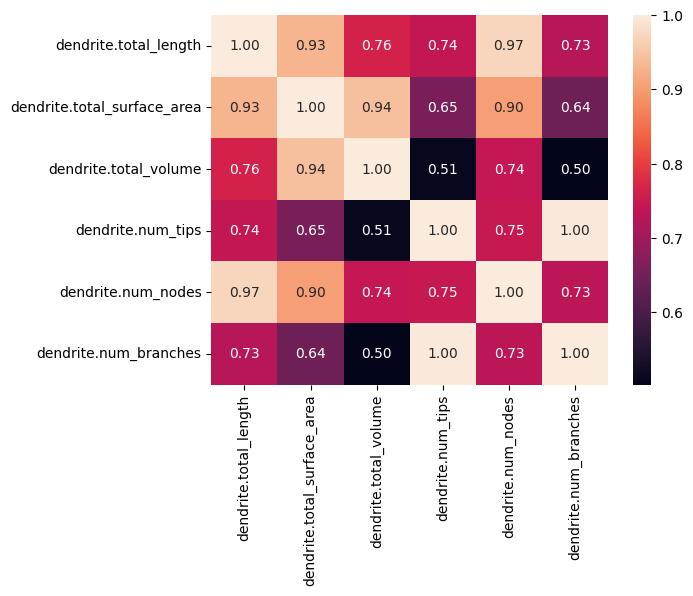

In [3]:
#Computing correlation heatmap for each dendrite feature.
sns.heatmap(cell_data[[col for col in cell_data.columns if col.startswith("dendrite")]].corr(), annot=True, fmt=".2f", annot_kws={"fontsize":10})

<Axes: xlabel='dendrite.num_branches', ylabel='dendrite.total_length'>

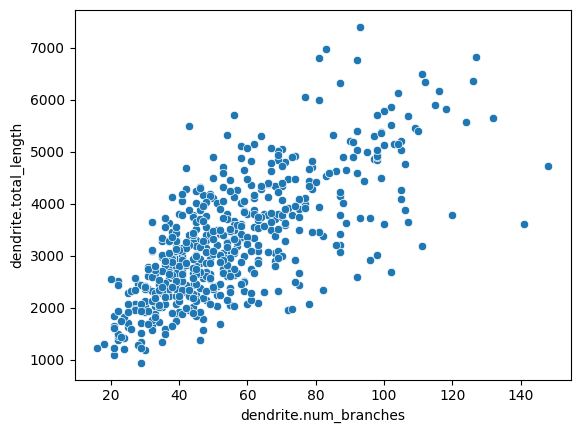

In [4]:
sns.scatterplot(x=cell_data["dendrite.num_branches"], y=cell_data["dendrite.total_length"])

We can get an overview and summary statistics of the data using `df.describe()`

In [5]:
cell_data["dendrite.num_branches"].describe()

,dendrite.num_branches
count,573.000000
mean,55.265271
std,22.805949
min,16.000000
25%,39.000000
50%,50.000000
75%,68.000000
max,148.000000


We can see that the most highly branched neuron has 148 branches, while the least has 16. The mean number of branches is 55.27 with a standard deviation of 22.81, indicating that the data is somewhat close to the mean.

A histogram shows the distribution of dendrite.num_branches:

<Axes: xlabel='dendrite.num_branches', ylabel='Count'>

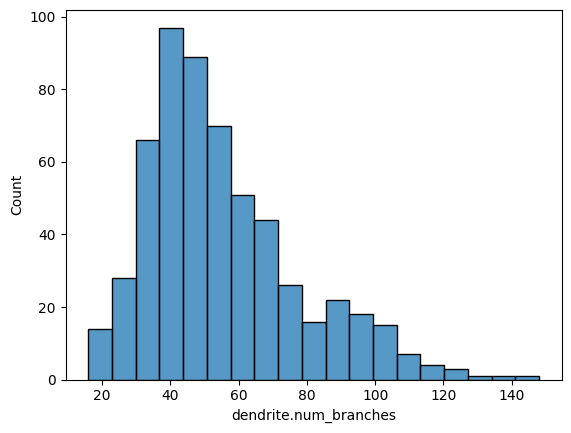

In [6]:
sns.histplot(cell_data["dendrite.num_branches"])

Next, we should determine if there is NA or missing data using `.isna()` and `.any()`.

In [7]:
cell_data["dendrite.num_branches"].isna().any()

False

We can see there is no missing data for dendrite.num_branches; however, we should also verify this for the gene expression data, which can be accessed using `cell_data.iloc[:, :-24]`.

In [8]:
cell_data.iloc[:, :-24].isna().any().any()

False

We should also examine the metadata, specifically neuron_reconstruction_type, to check the morphological data for any anomalies. First we combine `cell_data` and `cell_metadata` to get the metadata for the specific neurons in `cell_data`, as `cell_metadata` includes data for other neurons without morphological reconstructions. Printing the columns shows that the metadata is now included.

In [9]:
cell_data = cell_data.join(cell_metadata, how="inner")
cell_data.columns

Index(['0610005C13Rik', '0610006L08Rik', '0610007P14Rik', '0610009B22Rik',
       '0610009E02Rik', '0610009L18Rik', '0610009O20Rik', '0610010B08Rik',
       '0610010F05Rik', '0610010K14Rik',
       ...
       'apical_dendrite_status', 'neuron_reconstruction_type',
       'cell_soma_normalized_depth', 'depth_from_pia_um', 'ephys_session_id',
       'transcriptomics_sample_id', 'transcriptomics_batch',
       'T-type Accession ID', 'T-type Label', 'MET-type Label'],
      dtype='object', length=45814)

In [10]:
cell_data["neuron_reconstruction_type"].value_counts()

,count
neuron_reconstruction_type,
full,528
dendrite-only,45


By looking at the different reconstruction types, we can see that the majority of neurons have full reconstructions, while some have reconstructions of the dendrites only. Because we are focusing on dendritic morphology, these reconstructions should not affect the analysis. However, the histogram below shows that the distribution of these two reconstruction types are different. Interestingly, the dendrite-only reconstructions generally have higher numbers of branches. Investigation into the original paper and the Allen Institute website did not yield any insights into this.

<Axes: xlabel='dendrite.num_branches', ylabel='Count'>

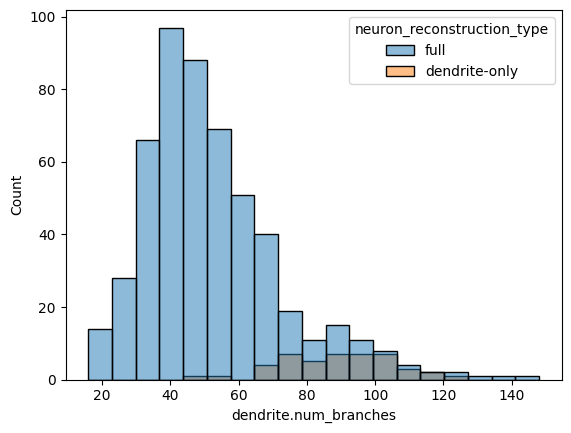

In [11]:
sns.histplot(data=cell_data, x='dendrite.num_branches', hue='neuron_reconstruction_type')

##GSEA Setup: The Ranking Metric and Ranked List of Genes

The first step of GSEA requires a list of all the genes in the dataset ranked by a suitable metric. There are multiple different metrics that can be used depending on the type of data, but the metric should ultimately reflect the correlation between a gene's expression level and the phenotype. GSEA is most often applied to datasets with two distinct classes or experimental conditions (e.g. normal cells vs. diseased cells) to identify pathways that are upregulated in one class/condition compared to the other. In that case, metrics based on the differential expression of each gene between the two classes is used, such as the signal-to-noise ratio, t-test, or fold change. For this analysis, we are analyzing a continuous phenotype where there are not two distinct classes. Therefore, we will use the Pearson correlation coefficent as our ranking metric instead.

In [12]:
 #Computing correlations between each gene with dendritic branching.
corrs = cell_data.iloc[:, :-46].corrwith(cell_data["dendrite.num_branches"])

#Ranking the list with the most correlated genes at the top.
corrs = corrs.sort_values(ascending=False)
corrs.head(7)

/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


,0
Arpp21,0.512190
Slc17a7,0.508691
Cacna2d1,0.499428
Ptprd,0.491913
R3hdm1,0.487666
Phactr1,0.482130
Nell2,0.480631


In [13]:
corrs.tail(7)

,0
n-R5s139,NaN
n-R5s141,NaN
n-R5s142,NaN
n-R5s143,NaN
n-R5s144,NaN
n-R5s146,NaN
n-R5s149,NaN


As we can see by printing the tail of `corrs`, some genes have NaN correlation values. This is because these genes are not expressed in any sample in the dataset, and thus there is no spread in the expression data (standard deviation = 0), resulting in an undefined value. These genes will not be relevant for the analysis and can be removed from the ranked list `corrs`.

In [14]:
corrs = corrs.dropna()
corrs.tail(7)

,0
Ube3a,-0.296282
Dpp6,-0.299590
Rab3b,-0.300480
Elavl2,-0.300543
Grip1,-0.303891
Kcnc2,-0.304194
Gria1,-0.315897


 A positive correlation indicates that a gene tends to be more expressed as the number of branches increase, suggesting that it is involved in promoting dendritic branching. Conversely, a negative correlation indicate that a gene is involved in the inhibition or downregulation of dendritic branching. Now that we have a ranked list of correlations, GSEA can determine which gene sets from a database are most associated (both positively and negatively) with dendritic branches based on the individual correlations of the set's constituent genes. GSEA calculates an enrichment score (ES) for each gene set, which, in this case, represents the correlation of the gene set with dendritc branching.

<Axes: ylabel='corr_val'>

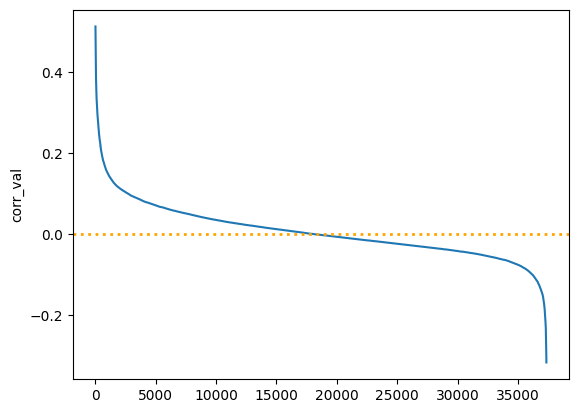

In [15]:
corrs = corrs.reset_index() #Resetting index to access the index as a column
corrs.columns = ["gene", "corr_val"]
corrplt = sns.lineplot(corrs["corr_val"]) #Showing how correlation value changes with gene rank
corrplt.axhline(y=0, linewidth=2, color='orange', ls=':')
corrplt

This line graph shows the correlation values of the genes. The x-axis is the rank of the gene within the sorted list. As this graph shows, the very extremes of the ranked list have relatively high correlations, which rapidly decline beyond  within the first 1000 genes. The GSEA algorithm weights the contribution of each gene to the ES based its correlation value, so low correlation genes will not affect the score a pathway receives too greatly, while highly correlated genes will have a larger impact.

#Gene Set Enrichment Analysis (GSEA)

##Selecting a Gene Set Database and Converting Gene Symbols

Next, we need to select gene set databases to analyze. GSEApy provides access to the [Enrichr](https://maayanlab.cloud/Enrichr/#libraries) and Molecular Signatures Database ([MSigDB](https://www.gsea-msigdb.org/gsea/msigdb)) APIs, which both hold a variety of gene set databases. MSigDB is the database collection introduced with the original GSEA paper (Subramanian et al., 2005), and has separate mouse and human databases. Enrichr merges mouse, human and rat data as described [here](https://pmc.ncbi.nlm.nih.gov/articles/PMC4987924/).

Gene symbols will also be important depending on the database you choose.
Mouse gene symbols have the first letter capitalized (e.g. Arpp21), whereas human gene symbols have all letters capitalized (ARPP21). In Enrichr, for example, gene symbols are all uppercase, so the mouse gene symbols in this data need to be converted. Many orthologous genes between mice and humans share the same gene symbol, however there are also some exceptoons. While you can just capitalize every gene symbol, it is better to map the genes by orthology. Genes are often converted for more obscure and less studied species that don't have gene set databases specific to them.

Since *Mus musculus* is one of the most common model organisms, there are many mouse-specific gene set databases and collections, so it is best to use those. Because this analysis was originally done using the Enrichr databases, ....(Will finish later)

###MSigDB

The Molecular Signatures Database (MSigDB) is a collection of gene sets and gene set databases created for the GSEA algorithm. It is divided into mouse and human-specific sections. It has a number of [gene set collections](https://www.gsea-msigdb.org/gsea/msigdb/mouse/collections.jsp?targetSpeciesDB=Mouse#MH), but we will focus on M2 curated gene sets and M5 ontology gene sets, as some of these were used in the original analysis. The curated collection has gene sets from commonly used pathway databases and online sources, such as [Reactome](https://reactome.org/) and [WikiPathways](https://www.wikipathways.org/). M5 also has the [Gene Ontology](https://geneontology.org/) (GO) sets. To access MSigDB, GSEApy provides methods to see and load the files; alternatively, you can download the .gmt files directly from the website.




In [16]:
from gseapy import Msigdb
msigdb = Msigdb()

#See all versions of MSigDB
msigdb.list_dbver()

,Name,Last modified
0,6.0,2018-12-17 16:29
1,6.1,2018-12-17 16:29
2,6.2,2018-12-17 16:29
3,7.0,2020-01-27 04:43
4,7.1,2020-03-30 16:55
5,7.2,2020-09-18 23:33
6,7.3,2021-03-22 15:09
7,7.4,2021-04-02 14:38
8,7.5.1,2023-03-09 19:38
9,7.5,2022-01-13 01:00


In [17]:
# list categories given version
msigdb.list_category(dbver="2024.1.Mm") # mouse

['m1.all',
 'm2.all',
 'm2.cgp',
 'm2.cp.biocarta',
 'm2.cp.reactome',
 'm2.cp',
 'm2.cp.wikipathways',
 'm3.all',
 'm3.gtrd',
 'm3.mirdb',
 'm5.all',
 'm5.go.bp',
 'm5.go.cc',
 'm5.go.mf',
 'm5.go',
 'm5.mpt',
 'm8.all',
 'mh.all',
 'msigdb']

###Enrichr

Enrichr is a web-based software tool for pathway enrichment analysis and has a large collection of gene set databases and libraries, including Reactome, wikiPathways, GO, and the Kyoto Encyclopedia of Genes and Genomes (KEGG), another well-known database. The databases can be accessed using this:

In [18]:
gp.get_library_name(organism="Mouse") #Shows all gene set databases

['ARCHS4_Cell-lines',
 'ARCHS4_IDG_Coexp',
 'ARCHS4_Kinases_Coexp',
 'ARCHS4_TFs_Coexp',
 'ARCHS4_Tissues',
 'Achilles_fitness_decrease',
 'Achilles_fitness_increase',
 'Aging_Perturbations_from_GEO_down',
 'Aging_Perturbations_from_GEO_up',
 'Allen_Brain_Atlas_10x_scRNA_2021',
 'Allen_Brain_Atlas_down',
 'Allen_Brain_Atlas_up',
 'Azimuth_2023',
 'Azimuth_Cell_Types_2021',
 'BioCarta_2013',
 'BioCarta_2015',
 'BioCarta_2016',
 'BioPlanet_2019',
 'BioPlex_2017',
 'CCLE_Proteomics_2020',
 'CORUM',
 'COVID-19_Related_Gene_Sets',
 'COVID-19_Related_Gene_Sets_2021',
 'Cancer_Cell_Line_Encyclopedia',
 'CellMarker_2024',
 'CellMarker_Augmented_2021',
 'ChEA_2013',
 'ChEA_2015',
 'ChEA_2016',
 'ChEA_2022',
 'Chromosome_Location',
 'Chromosome_Location_hg19',
 'ClinVar_2019',
 'DGIdb_Drug_Targets_2024',
 'DSigDB',
 'Data_Acquisition_Method_Most_Popular_Genes',
 'DepMap_CRISPR_GeneDependency_CellLines_2023',
 'DepMap_WG_CRISPR_Screens_Broad_CellLines_2019',
 'DepMap_WG_CRISPR_Screens_Sanger_Cell

To use the Enrichr libraries, we need to first convert our mouse gene symbols to human ones. The BioMart api allows us to map the genes by orthology. In addition to the corresponding gene id and name, we can also get the orthology type, orthology confidence, and percentage similarity, which will be useful for mapping the genes.



In [45]:
from gseapy import Biomart
bm = Biomart()
m2h = bm.query(dataset='mmusculus_gene_ensembl',
               attributes=['ensembl_gene_id','external_gene_name',
                           'hsapiens_homolog_ensembl_gene',
                           'hsapiens_homolog_associated_gene_name',
                           "hsapiens_homolog_orthology_type",
                           "hsapiens_homolog_orthology_confidence",
                           "hsapiens_homolog_perc_id",
                           ])


Query ERROR: caught BioMart::Exception::Database: Could not connect to mysql database ensembl_mart_113: DBI connect('database=ensembl_mart_113;host=127.0.0.1;port=5316','ensro',...) failed: Can't connect to MySQL server on '127.0.0.1' (111) at /nfs/public/ro/ensweb/live/mart/www_113/biomart-perl/lib/BioMart/Configuration/DBLocation.pm line 98.



In [25]:
m2h.loc[m2h["external_gene_name"].isin(corrs["gene"])].sample(10) #Getting a random sample of the orthology mapping for genes in our dataset

,ensembl_gene_id,external_gene_name,hsapiens_homolog_ensembl_gene,hsapiens_homolog_associated_gene_name,hsapiens_homolog_orthology_type,hsapiens_homolog_orthology_confidence,hsapiens_homolog_perc_id
20533,ENSMUSG00000040127,Sdr9c7,ENSG00000170426,SDR9C7,ortholog_one2one,1.0,84.6645
29928,ENSMUSG00000061689,Dlgap4,ENSG00000080845,DLGAP4,ortholog_one2one,1.0,96.9758
33930,ENSMUSG00000112937,Gm17746,NaN,NaN,NaN,NaN,NaN
54807,ENSMUSG00000074971,Fibin,ENSG00000176971,FIBIN,ortholog_one2one,1.0,90.7834
4586,ENSMUSG00000083210,Gm14869,NaN,NaN,NaN,NaN,NaN
30080,ENSMUSG00000090173,Fbxw10,ENSG00000171931,FBXW10,ortholog_one2many,1.0,70.9709
20417,ENSMUSG00000089789,Rdh1,ENSG00000139547,RDH16,ortholog_one2many,1.0,74.1325
4529,ENSMUSG00000037148,Arhgap10,ENSG00000071205,ARHGAP10,ortholog_one2one,1.0,91.4758
24881,ENSMUSG00000048000,Gigyf2,ENSG00000204120,GIGYF2,ortholog_one2one,1.0,94.8877
45715,ENSMUSG00000055148,Klf2,ENSG00000127528,KLF2,ortholog_one2one,1.0,87.2881


In [39]:
x= ((m2h.loc[m2h["external_gene_name"].isin(corrs["gene"])]).loc[(m2h.loc[m2h["external_gene_name"].isin(corrs["gene"])])["hsapiens_homolog_orthology_type"] == "ortholog_one2many"])

In [43]:
x.head(10)

,ensembl_gene_id,external_gene_name,hsapiens_homolog_ensembl_gene,hsapiens_homolog_associated_gene_name,hsapiens_homolog_orthology_type,hsapiens_homolog_orthology_confidence,hsapiens_homolog_perc_id
608,ENSMUSG00000100032,Gm20817,ENSG00000139351,SYCP3,ortholog_one2many,0.0,27.4775
665,ENSMUSG00000100535,Gm20870,ENSG00000139351,SYCP3,ortholog_one2many,0.0,27.4775
733,ENSMUSG00000100902,Gm20850,ENSG00000139351,SYCP3,ortholog_one2many,0.0,27.4775
908,ENSMUSG00000100240,Gm20820,ENSG00000139351,SYCP3,ortholog_one2many,0.0,27.0270
939,ENSMUSG00000099856,Gm20906,ENSG00000139351,SYCP3,ortholog_one2many,0.0,27.4775
997,ENSMUSG00000100045,Gm20929,ENSG00000139351,SYCP3,ortholog_one2many,0.0,27.4775
1331,ENSMUSG00000100939,Gm28998,ENSG00000139351,SYCP3,ortholog_one2many,0.0,27.4775
1343,ENSMUSG00000100645,Gm28576,ENSG00000139351,SYCP3,ortholog_one2many,0.0,27.4775
1672,ENSMUSG00000101155,Sly,ENSG00000139351,SYCP3,ortholog_one2many,0.0,27.4775
1714,ENSMUSG00000094570,Gm20931,ENSG00000139351,SYCP3,ortholog_one2many,0.0,27.4775


In [44]:
m2h.loc[m2h["external_gene_name"].isin(corrs["gene"])]

,count
hsapiens_homolog_orthology_type,
ortholog_one2one,17137
ortholog_many2many,5607
ortholog_one2many,3024


As you can see, there are a few different types of orthologs. A `one2one` type indicates that the gene has only one ortholog in the other species and vice versa. `many2many` indicates that there are multiple orthologs on both sides, which is the result of gene duplication in both species after they diverged.`one2many` indicates that a gene has multiple ortho

In [38]:

#Gm16367
converted_corrs = pd.merge(corrs, m2h[["external_gene_name", "hsapiens_homolog_associated_gene_name"]], left_on="gene", right_on="external_gene_name", how="left")
converted_corrs = converted_corrs.drop(columns=["external_gene_name"])
converted_corrs

,gene,corr_val,hsapiens_homolog_associated_gene_name
0,Arpp21,0.512190,ARPP21
1,Slc17a7,0.508691,SLC17A7
2,Cacna2d1,0.499428,CACNA2D1
3,Ptprd,0.491913,PTPRD
4,R3hdm1,0.487666,R3HDM1
...,...,...,...
38486,Rab3b,-0.300480,RAB3B
38487,Elavl2,-0.300543,ELAVL2
38488,Grip1,-0.303891,GRIP1
38489,Kcnc2,-0.304194,KCNC2


In [53]:
converted_corrs.loc[converted_corrs["gene"] == "Zfy1"]

,gene,corr_val,hsapiens_homolog_associated_gene_name
12904,Zfy1,0.022749,ZNF549
12905,Zfy1,0.022749,ZNF552
12906,Zfy1,0.022749,ZNF587B
12907,Zfy1,0.022749,ZNF586
12908,Zfy1,0.022749,ZNF418
12909,Zfy1,0.022749,ZNF584
12910,Zfy1,0.022749,ZNF134
12911,Zfy1,0.022749,ZNF256
12912,Zfy1,0.022749,ZNF154
12913,Zfy1,0.022749,ZNF772


In [ ]:
#geneData.columns = geneData.columns.str.upper() #Making all gene identifiers uppercase for the correct gseapy/enrichr format (NOTE: Only if using the databases attached to gseapy/enrichr, which can be found with this gp.get_library_name(organism="Mouse"))

##Functions for GSEA and Visualizations

GSEApy provides a few different functions to perform the analysis (see the developmental guide [here](https://gseapy.readthedocs.io/en/latest/run.html)), including `gp.gsea()` and `gp.prerank()`. `gp.gsea()` only supports categorical data and specific ranking metrics based on differential expression. Since we're analyzing continuous data, we'll use `gp.prerank()`, which allows us to pre-rank the genes using our own ranking metric, Pearson correlation.  


```
output = gp.prerank(rnk=corrs, gene_sets= .gmt file or Enrichr database name)
```

We can also use `gseaplot()` to create a gsea plot which shows the distribution of the gene set across the ranked list, the ES calculation, and other key statistics for a given set.

```
gseaplot(term="gene set name", rank_metric=output.ranking, **output.results["gene set name"])
```

We'll also write a function that creates a network visualization of the results using `enrichment_map()`. Each node represents a gene set with the color representing the NES. The width of the edges connecting each node indicates the similarity of the gene sets based on the Jaccard coefficient. This graph will alllow us to vizualize the connections between the enriched gene sets.




In [ ]:
#Code adapted from example in documentation: https://gseapy.readthedocs.io/en/latest/gseapy_example.html#Prerank-example

def network_visualization(output, col = "FDR q-val", top_term = 20, cutoff=0.05, k = None, dimensions = (7, 7), title = None):
  '''
  output: Output object from gp.prerank()
  col" The column the nodes will be based on. To show most significant results use: "Adjusted P-value", "P-value", "FDR q-val", or "NOM p-val". To show results based on NES, use "NES".
  top_term: The number of gene sets you want to graph
  cut_off: The cutoff for the significance value
  k: The k parameter for the spring layout as described in the networkx documentation. Adjust this value to change node spacing. https://networkx.org/documentation/stable/reference/generated/networkx.drawing.layout.spring_layout.html
  dimensions: The dimensions of the graph as a tuple
  title: Title of the visualization (e.g. "Reactome")
  '''

  nodes, edges = enrichment_map(output.res2d, column = col, cutoff = cutoff, top_term = top_term)

  #Creates a graph, G. The source and targets columns of the edges dataframe define node connections and edge_attr specifies attributes for the edges.
  G = nx.from_pandas_edgelist(edges,
                            source="src_idx",
                            target="targ_idx",
                            edge_attr=["jaccard_coef", "overlap_coef", "overlap_genes"])

  #Added this code to add any missing nodes.
  for node in nodes.index:
        if node not in G:
            G.add_node(node)

  fig, ax = plt.subplots(figsize = dimensions)

  # init node coordinates with spring layout
  pos=nx.layout.spring_layout(G, k = k)

  # draws the nodes
  nx.draw_networkx_nodes(G,
                        pos=pos,
                        cmap=plt.cm.RdYlBu if col in ["Adjusted P-value", "P-value", "FDR q-val", "NOM p-val"] else plt.cm.Blues,# Use plt.cm.RdYlBu if the enrichment_map() column argument is FDR q-val. Use plt.cm.Blues if you set it to NES.
                        nodelist=nodes.index, #This fixed the node coloring issue. This puts the nodes in the correct order.
                        node_color=list(nodes.NES),
                        node_size=list(nodes.Hits_ratio *1000)
                        )

  # draws the node labels
  nodes["term_shortened"] = nodes.Term.apply(lambda x: "_".join(x.split()[:4]) if len(x.split()) <= 5 else f"{'_'.join(x.split()[:4])}...") #Makes shortened terms with 5 words or less If it was longer than 5 originally it adds ...
  nx.draw_networkx_labels(G,
                          pos=pos,
                          labels=nodes["term_shortened"].to_dict(),
                          font_size=10) #nodes.Term.to_dict()
  # draws the edges
  edge_weight = nx.get_edge_attributes(G, 'jaccard_coef').values()
  nx.draw_networkx_edges(G,
                        pos=pos,
                        width=list(map(lambda x: x*10, edge_weight)),
                        edge_color='#CDDBD4')
  plt.title(title)
  plt.show()

  print(nodes.Term)


##Reactome

In [ ]:
reactome_out = gp.prerank(rnk=corrs, gene_sets=msigdb.get_gmt(category="m2.cp.reactome", dbver="2024.1.Mm"))
reactome_res = reactome_out.res2d.sort_values(by="NES",ascending=False).reset_index(drop=True) #Sorting by NES

2025-03-14 02:45:34,254 [WARNING] Duplicated values found in preranked stats: 4.24% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


In [ ]:
reactome_res.head(20)

,index,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,3,prerank,REACTOME_NONSENSE_MEDIATED_DECAY_NMD_INDEPENDE...,0.632828,2.319791,0.0,0.0,0.0,76/95,30.13%,Rps14;Pabpc1;Rplp2;Rpl31;Rpl9;Rpl37a;Rpl32;Rps...
1,6,prerank,REACTOME_EUKARYOTIC_TRANSLATION_INITIATION,0.580016,2.176874,0.0,0.000882,0.002,70/120,24.16%,Rps14;Pabpc1;Rplp2;Rpl31;Rpl9;Eif3f;Eif4a1;Eif...
2,7,prerank,REACTOME_NONSENSE_MEDIATED_DECAY_NMD,0.578566,2.175764,0.0,0.000588,0.002,73/114,23.99%,Rps14;Pabpc1;Rplp2;Rpl31;Rpl9;Rpl37a;Ppp2r2a;R...
3,8,prerank,REACTOME_ACTIVATION_OF_THE_MRNA_UPON_BINDING_O...,0.614076,2.082631,0.0,0.001544,0.005,36/60,24.16%,Rps14;Pabpc1;Eif3f;Eif4a1;Eif4ebp1;Rps16;Rps6;...
4,9,prerank,REACTOME_CA2_PATHWAY,0.648309,2.078438,0.0,0.001235,0.005,16/45,11.39%,Ppp3ca;Calm1;Nlk;Calm2;Camk2a;Ppp3r1;Fzd3;Calm...
5,10,prerank,REACTOME_PROTEIN_PROTEIN_INTERACTIONS_AT_SYNAPSES,0.607693,2.066339,0.0,0.001324,0.007,25/61,11.23%,Ptprd;Nlgn1;Sorbs2;Dlg1;Il1rap;Grin2a;Homer1;D...
6,12,prerank,REACTOME_UNBLOCKING_OF_NMDA_RECEPTORS_GLUTAMAT...,0.734266,2.046338,0.0,0.001639,0.01,13/22,8.18%,Dlg1;Lrrc7;Grin2a;Calm1;Nefl;Calm2;Camk2a;Calm...
7,13,prerank,REACTOME_RAF_INDEPENDENT_MAPK1_3_ACTIVATION,0.74627,2.045592,0.0,0.001434,0.01,10/22,8.53%,Dusp6;Dusp7;Dusp5;Map2k1;Dusp4;Mapk1;Il6ra;Jak...
8,14,prerank,REACTOME_ACTIVATION_OF_NMDA_RECEPTORS_AND_POST...,0.668371,2.02597,0.0,0.002255,0.018,17/35,8.18%,Dlg1;Lrrc7;Grin2a;Camkk2;Calm1;Nefl;Calm2;Camk...
9,15,prerank,REACTOME_ION_HOMEOSTASIS,0.600478,2.004678,0.0,0.002823,0.023,20/52,5.92%,Atp2b1;Atp1a1;Itpr1;Atp2b2;Atp2b4;Fxyd7;Calm1;...


In [ ]:
reactome_res.tail(20)

,index,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
752,74,prerank,REACTOME_TRAFFICKING_OF_GLUR2_CONTAINING_AMPA_...,-0.572765,-1.663771,0.030303,0.141444,0.798,6/16,4.39%,Gria1;Grip1;Grip2;Pick1;Prkcg;Gria4
753,72,prerank,REACTOME_PROCESSING_OF_INTRONLESS_PRE_MRNAS,-0.544442,-1.673554,0.008929,0.13664,0.771,8/20,10.39%,Pabpn1;Cstf2;Sympk;Cpsf6;Cpsf3;Nudt21;Ncbp2;Cpsf4
754,69,prerank,REACTOME_GABA_SYNTHESIS_RELEASE_REUPTAKE_AND_D...,-0.5341,-1.681875,0.01506,0.136085,0.753,9/19,5.38%,Cplx1;Slc32a1;Gad1;Gad2;Abat;Rab3a;Slc6a1;Aldh...
755,61,prerank,REACTOME_SYNTHESIS_OF_VERY_LONG_CHAIN_FATTY_AC...,-0.567664,-1.728578,0.008646,0.100254,0.634,6/18,2.48%,Tecr;Acsl6;Hsd17b12;Elovl5;Acsl3;Acsl1
756,58,prerank,REACTOME_INSULIN_RECEPTOR_RECYCLING,-0.496141,-1.734591,0.006873,0.102064,0.624,14/29,19.96%,Atp6ap1;Atp6v0c;Atp6v1g2;Atp6v1h;Atp6v0b;Atp6v...
757,49,prerank,REACTOME_BIOSYNTHESIS_OF_THE_N_GLYCAN_PRECURSO...,-0.411162,-1.770326,0.0,0.079365,0.514,23/73,9.91%,St8sia1;Alg2;St6galnac5;Glb1;Gmds;Cmas;Slc35a1...
758,42,prerank,REACTOME_CONVERSION_FROM_APC_C_CDC20_TO_APC_C_...,-0.580703,-1.814578,0.006042,0.056593,0.378,10/20,25.39%,Anapc4;Fzr1;Ube2d1;Anapc7;Ube2c;Anapc1;Anapc2;...
759,39,prerank,REACTOME_TRANSFERRIN_ENDOCYTOSIS_AND_RECYCLING,-0.511394,-1.832646,0.0,0.048943,0.321,16/31,19.96%,Atp6ap1;Atp6v0c;Atp6v1g2;Atp6v1h;Atp6v0b;Atp6v...
760,32,prerank,REACTOME_GLUCONEOGENESIS,-0.588734,-1.875272,0.003257,0.036992,0.239,17/23,24.74%,Pck2;Slc37a1;Gpi1;Eno2;Tpi1;Slc37a4;Gapdh;G6pc...
761,27,prerank,REACTOME_IRON_UPTAKE_AND_TRANSPORT,-0.471706,-1.900632,0.0,0.029716,0.185,25/53,19.96%,Slc22a17;Atp6ap1;Atp6v0c;Atp6v1g2;Atp6v1h;Atp6...


[<Axes: xlabel='Gene Rank', ylabel='Ranked metric'>,
 <Axes: >,
 <Axes: >,
 <Axes: ylabel='Enrichment Score'>]

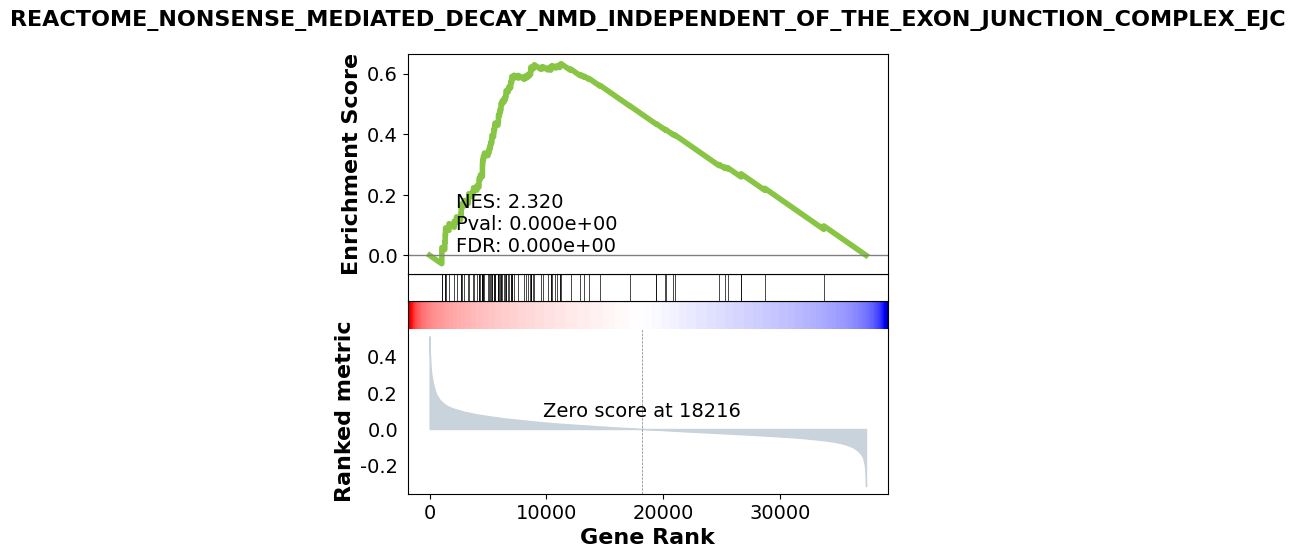

In [ ]:
gseaplot(term=reactome_res.loc[0]["Term"], rank_metric=reactome_out.ranking, **reactome_out.results[reactome_res.loc[0]["Term"]])

/usr/local/lib/python3.11/dist-packages/gseapy/plot.py:738: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[self.colname] = df[self.colname].replace(0, np.nan).bfill()


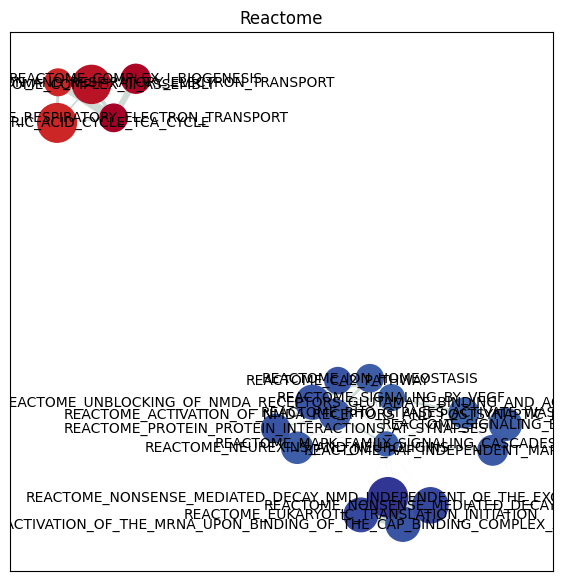

node_idx
0         REACTOME_RHO_GTPASES_ACTIVATE_WASPS_AND_WAVES
1                            REACTOME_SIGNALING_BY_VEGF
2                         REACTOME_SIGNALING_BY_ACTIVIN
3               REACTOME_MAPK_FAMILY_SIGNALING_CASCADES
4                    REACTOME_NEUREXINS_AND_NEUROLIGINS
5                              REACTOME_ION_HOMEOSTASIS
6     REACTOME_ACTIVATION_OF_NMDA_RECEPTORS_AND_POST...
7     REACTOME_UNBLOCKING_OF_NMDA_RECEPTORS_GLUTAMAT...
8     REACTOME_ACTIVATION_OF_THE_MRNA_UPON_BINDING_O...
9           REACTOME_RAF_INDEPENDENT_MAPK1_3_ACTIVATION
10    REACTOME_PROTEIN_PROTEIN_INTERACTIONS_AT_SYNAPSES
11                                 REACTOME_CA2_PATHWAY
12           REACTOME_EUKARYOTIC_TRANSLATION_INITIATION
13                 REACTOME_NONSENSE_MEDIATED_DECAY_NMD
14                 REACTOME_CITRIC_ACID_CYCLE_TCA_CYCLE
15    REACTOME_AEROBIC_RESPIRATION_AND_RESPIRATORY_E...
16    REACTOME_NONSENSE_MEDIATED_DECAY_NMD_INDEPENDE...
17                        REACTOME_COMP

In [ ]:
network_visualization(reactome_out, col = "FDR q-val", top_term = 20, cutoff=0.05, k = 1/3, dimensions = (7, 7), title = "Reactome")

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/pairwise.py:2466: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/pairwise.py:2466: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/pairwise.py:2466: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/pairwise.py:2466: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/pairwise.py:2466: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/me

Score: 0.008445163541765804, threshold: 0.189873417721519
Score: 0.05349457035315226, threshold: 0.2228513356562137
Score: 0.08996515858844638, threshold: 0.23529411764705882
Score: 0.11438074300403081, threshold: 0.3103448275862069
Score: 0.1380210986171755, threshold: 0.3611111111111111
Score: 0.1620359409177321, threshold: 0.48
Score: 0.18197921603342104, threshold: 0.4827586206896552
Score: 0.18231041121772265, threshold: 0.5516304347826086
Score: 0.198194920250774, threshold: 0.5685207796318906
Score: 0.20516027384865157, threshold: 0.6215277777777778
Score: 0.2126820057160588, threshold: 0.6570655848546315
Score: 0.22581847479573472, threshold: 0.68
Score: 0.21491260646398672, threshold: 0.7058823529411764
Score: 0.21877267757099683, threshold: 0.7461890243902439
Score: 0.22241929563858046, threshold: 0.794392523364486
Score: 0.22166632832892652, threshold: 0.8026483320600967
Score: 0.19576241054834967, threshold: 0.8258392663740711
Score: 0.1951271042717392, threshold: 0.8303571

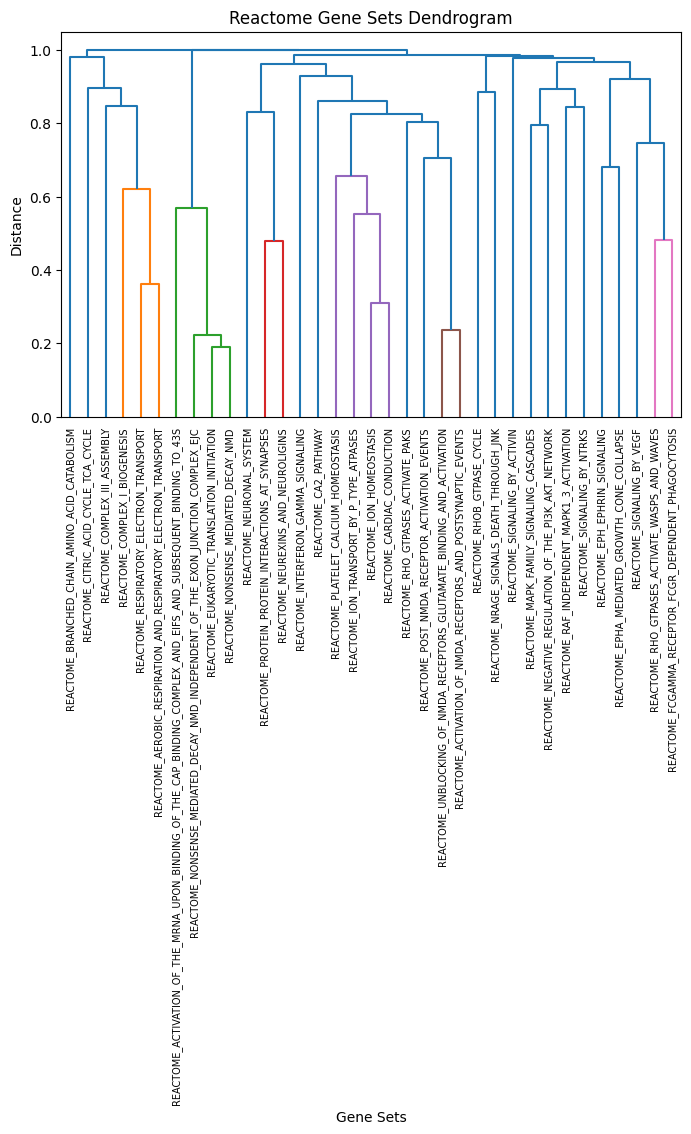

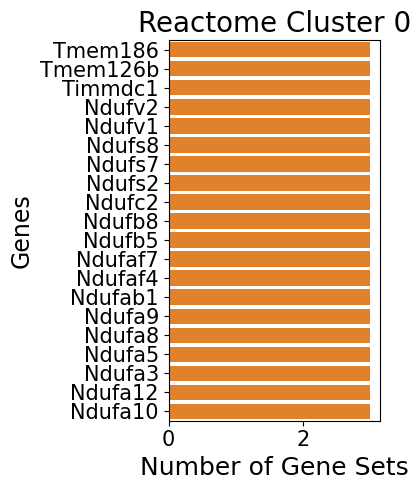

['REACTOME_RESPIRATORY_ELECTRON_TRANSPORT', 'REACTOME_COMPLEX_I_BIOGENESIS', 'REACTOME_AEROBIC_RESPIRATION_AND_RESPIRATORY_ELECTRON_TRANSPORT']


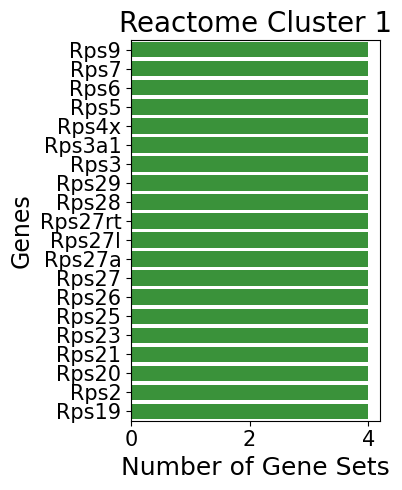

['REACTOME_NONSENSE_MEDIATED_DECAY_NMD_INDEPENDENT_OF_THE_EXON_JUNCTION_COMPLEX_EJC', 'REACTOME_EUKARYOTIC_TRANSLATION_INITIATION', 'REACTOME_NONSENSE_MEDIATED_DECAY_NMD', 'REACTOME_ACTIVATION_OF_THE_MRNA_UPON_BINDING_OF_THE_CAP_BINDING_COMPLEX_AND_EIFS_AND_SUBSEQUENT_BINDING_TO_43S']


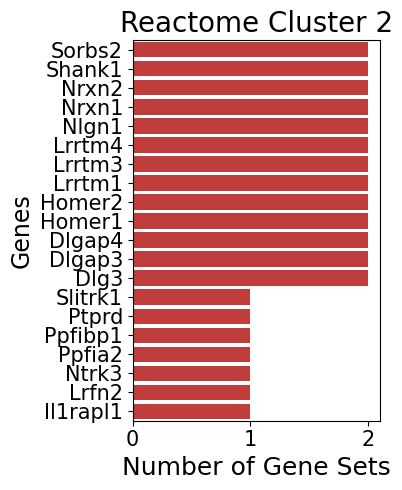

['REACTOME_PROTEIN_PROTEIN_INTERACTIONS_AT_SYNAPSES', 'REACTOME_NEUREXINS_AND_NEUROLIGINS']


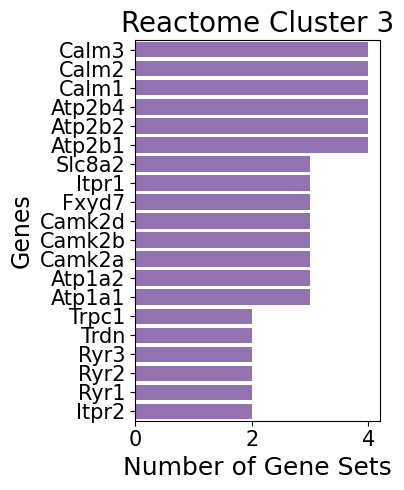

['REACTOME_ION_HOMEOSTASIS', 'REACTOME_PLATELET_CALCIUM_HOMEOSTASIS', 'REACTOME_ION_TRANSPORT_BY_P_TYPE_ATPASES', 'REACTOME_CARDIAC_CONDUCTION']


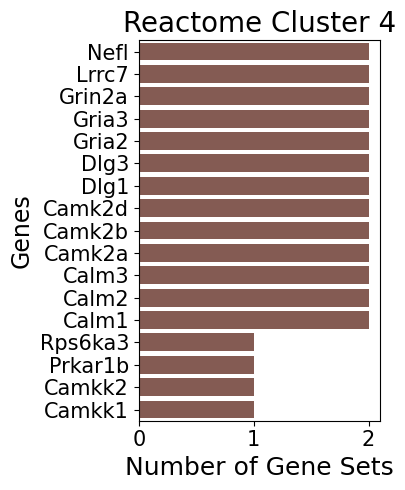

['REACTOME_UNBLOCKING_OF_NMDA_RECEPTORS_GLUTAMATE_BINDING_AND_ACTIVATION', 'REACTOME_ACTIVATION_OF_NMDA_RECEPTORS_AND_POSTSYNAPTIC_EVENTS']


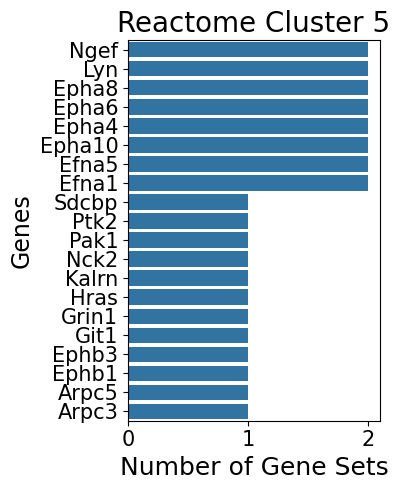

['REACTOME_EPH_EPHRIN_SIGNALING', 'REACTOME_EPHA_MEDIATED_GROWTH_CONE_COLLAPSE']


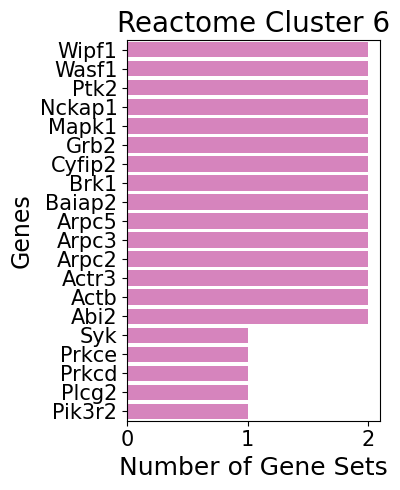

['REACTOME_RHO_GTPASES_ACTIVATE_WASPS_AND_WAVES', 'REACTOME_FCGAMMA_RECEPTOR_FCGR_DEPENDENT_PHAGOCYTOSIS']


In [ ]:
generate_leading_edge_report(reactome_out, reactome_res.loc[reactome_res["FDR q-val"] < 0.02].iloc[:,2], reactome_res, "Reactome")

##Kyoto Encyclopedia of Genes and Genomes (KEGG)

In [ ]:
# reactome_out = gp.prerank(rnk=corrs, gene_sets=msigdb.get_gmt(category="m2.cp.reactome", dbver="2024.1.Mm"))
# reactome_res = reactome_out.res2d.sort_values(by="NES",ascending=False).reset_index(drop=True) #Sorting by NES

##Gene Ontology (GO) Biological Process

In [ ]:
gobp_out = gp.prerank(rnk=corrs, gene_sets=msigdb.get_gmt(category="m5.go.bp", dbver="2024.1.Mm"))
gobp_res = gobp_out.res2d.sort_values(by="NES",ascending=False).reset_index(drop=True) #Sorting by NES

2025-03-05 14:27:19,940 [WARNING] Duplicated values found in preranked stats: 4.24% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


In [ ]:
gobp_res.head(20)

,index,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,4,prerank,GOBP_POSTSYNAPSE_ASSEMBLY,0.658187,2.339649,0.0,0.0,0.0,26/83,4.26%,Ptprd;Nlgn1;Ptk2b;Sipa1l1;Numb;Lzts1;Rtn4r;Il1...
1,5,prerank,GOBP_REGULATION_OF_POSTSYNAPSE_ORGANIZATION,0.596376,2.321602,0.0,0.0,0.0,54/170,6.95%,Ptprd;Nlgn1;Ptk2b;Itpka;Epha4;Kalrn;Baiap2;Nge...
2,6,prerank,GOBP_POSTSYNAPTIC_SPECIALIZATION_ASSEMBLY,0.72111,2.303534,0.0,0.0,0.0,18/43,4.26%,Ptprd;Nlgn1;Ptk2b;Sipa1l1;Il1rap;Ntng2;Abi3bp;...
3,7,prerank,GOBP_POSITIVE_REGULATION_OF_EXCITATORY_POSTSYN...,0.715581,2.288984,0.0,0.0,0.0,17/40,5.44%,Nlgn1;Ptk2b;Baiap2;Stx1a;Cux2;Grin2a;Rgs4;Nrxn...
4,8,prerank,GOBP_REGULATION_OF_POSTSYNAPTIC_SPECIALIZATION...,0.806218,2.284796,0.0,0.0,0.0,13/25,4.26%,Ptprd;Nlgn1;Ptk2b;Sipa1l1;Il1rap;Abi3bp;Nrxn1;...
5,11,prerank,GOBP_POSTSYNAPTIC_SPECIALIZATION_ORGANIZATION,0.672143,2.251233,0.0,0.000341,0.002,25/62,5.44%,Ptprd;Nlgn1;Ptk2b;Cnksr2;Sipa1l1;Il1rap;Ntng2;...
6,13,prerank,GOBP_POSTSYNAPSE_ORGANIZATION,0.555903,2.238684,0.0,0.000292,0.002,102/278,11.56%,Ptprd;Nlgn1;Ptk2b;Itpka;Epha4;Cnksr2;Kalrn;Bai...
7,15,prerank,GOBP_REGULATION_OF_DENDRITIC_SPINE_MORPHOGENESIS,0.661438,2.22891,0.0,0.000256,0.002,22/59,6.95%,Nlgn1;Itpka;Epha4;Kalrn;Baiap2;Ngef;Sipa1l1;Cu...
8,16,prerank,GOBP_POSTSYNAPTIC_DENSITY_ASSEMBLY,0.734712,2.226546,0.0,0.000227,0.002,14/33,4.26%,Ptprd;Nlgn1;Ptk2b;Sipa1l1;Il1rap;Abi3bp;C1ql3;...
9,17,prerank,GOBP_REGULATION_OF_SYNAPSE_STRUCTURE_OR_ACTIVITY,0.541438,2.210477,0.0,0.000204,0.002,114/359,9.26%,Slc17a7;Ptprd;Nlgn1;Ptk2b;Itpka;Bdnf;Neurod2;E...


In [ ]:
gobp_res.tail(20)

,index,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
4152,58,prerank,GOBP_METALLO_SULFUR_CLUSTER_ASSEMBLY,-0.641618,-2.070615,0.0,0.008221,0.148,10/21,9.22%,Fxn;Nfs1;Ciapin1;Abcb7;Hspa9;AK157302;Iscu;Lyr...
4153,57,prerank,GOBP_GAMMA_AMINOBUTYRIC_ACID_TRANSPORT,-0.606029,-2.075061,0.0,0.008165,0.142,8/25,4.59%,Sv2a;Trpc4;Slc32a1;Abat;Slc7a14;Grik1;Slc6a1;H...
4154,53,prerank,GOBP_BRANCHED_CHAIN_AMINO_ACID_METABOLIC_PROCESS,-0.610746,-2.083972,0.0,0.007587,0.125,10/25,7.63%,Bckdhb;Bcat1;Hibadh;Dld;Acat1;Ilvbl;Acadsb;Auh...
4155,49,prerank,GOBP_LYSOSOMAL_LUMEN_ACIDIFICATION,-0.70791,-2.089851,0.0,0.007322,0.117,8/15,12.54%,Atp6ap2;Atp6v0c;Lamp1;Tmem106b;Tmem9;Ppt1;Snap...
4156,47,prerank,GOBP_POSITIVE_REGULATION_OF_MEMBRANE_POTENTIAL,-0.657783,-2.091533,0.0,0.00778,0.117,10/22,14.58%,Gria1;Mfn1;Tmem135;Ndufc2;Vcp;Glrx;Akt1;Drd1;B...
4157,45,prerank,GOBP_ATP_BIOSYNTHETIC_PROCESS,-0.488327,-2.095282,0.0,0.007927,0.113,25/69,13.34%,Ndufs2;Slc25a12;Ndufv2;Ndufa8;Ndufs7;Sdha;Nduf...
4158,42,prerank,GOBP_ATP_SYNTHESIS_COUPLED_ELECTRON_TRANSPORT,-0.505884,-2.100194,0.0,0.008095,0.108,29/64,13.21%,Ndufs2;Cyc1;Ndufv2;Uqcrc1;Cox6a2;Cox7b;Ndufa8;...
4159,40,prerank,GOBP_PROTEIN_CATABOLIC_PROCESS_IN_THE_VACUOLE,-0.64402,-2.107591,0.0,0.007932,0.098,9/22,8.81%,Laptm4b;Psap;Atp13a2;Cd81;Vps35;Tcirg1;Ldlr;Tm...
4160,38,prerank,GOBP_CELLULAR_RESPIRATION,-0.410004,-2.112559,0.0,0.008051,0.091,70/202,13.34%,Ndufs2;Slc25a12;Mdh1;Tmem135;Cyc1;Idh3a;Ndufv2...
4161,31,prerank,GOBP_OXIDATIVE_PHOSPHORYLATION,-0.468422,-2.136287,0.0,0.005996,0.061,41/110,13.34%,Ndufs2;Tmem135;Cyc1;Ndufv2;Uqcrc1;Cox6a2;Cox7b...


##GO Molecular Function

In [ ]:
gomf_out = gp.prerank(rnk=corrs, gene_sets=msigdb.get_gmt(category="m5.go.mf", dbver="2024.1.Mm"))
gomf_res = gomf_out.res2d.sort_values(by="NES",ascending=False).reset_index(drop=True) #Sorting by NES

##GO Cellular Component

In [ ]:
gocc_out = gp.prerank(rnk=corrs, gene_sets=msigdb.get_gmt(category="m5.go.cc", dbver="2024.1.Mm"))
gocc_res = gocc_out.res2d.sort_values(by="NES",ascending=False).reset_index(drop=True) #Sorting by NES

#Leading-Edge Subset Analysis

Next, we will analyze the leading-edge subsets of the enriched gene sets to identify important genes. The paper defines the leading-edge subset as follows:
> "We define the leading-edge subset to be those genes in the gene set S that appear in the ranked list L at, or before, the point where the running sum reaches its maximum deviation from zero ( Fig. 1B). The leading-edge subset can be interpreted as the core of a gene set that accounts for the enrichment signal."

The leading-edge genes are the genes that are most biologically relevant within the gene set. We can cluster the significant gene sets based on the similarity of their leading edges to create groups that have common biological function. If the leading-edge subsets of two gene sets are similar, they likely correspond to the same or a related process. We can also examine the gene overlap of all the leading-edge subsets in a cluster to find individual genes that are centrally important in that cluster.

##Clustering and Visualization Functions

We will use agglomerative hierarchical clustering to cluster our gene sets based on leading edge similarity. The Jaccard coefficient is used as a metric of gene membership similarity. Agglomerative hierarchical clustering is a bottom-up approach that groups similar data points (gene sets) into a hierarchy of clusters. Each data point is initially treated as an individual cluster and then the algorithm iteratively merges the closest pair based on a distance metric (jaccard in this case) and linkage criterion.

In [ ]:
#Based on https://rdrr.io/bioc/GSEAmining/src/R/gm_clust.R
def cluster_results(output, gene_sets):
  '''
  output: output object from gp.prerank()
  gene_sets: The gene sets to be clustered inputted as a list.
  '''

  res_df = output.res2d
  res_df = res_df.loc[res_df["Term"].isin(gene_sets)] #Getting the gene sets the user wants to analyze

  #Creating the document term matrix (dtm), which indicates whether each gene is present for each gene set.
  vectorizer = CountVectorizer(tokenizer=lambda x: x.split(";"), token_pattern=None)
  X = vectorizer.fit_transform(res_df["Lead_genes"])
  dtm = pd.DataFrame(X.toarray(), index=res_df["Term"], columns=vectorizer.get_feature_names_out())

  #Creating the distance matrix, computes pairwise Jaccard distance (similarity) between gene sets.
  distance_matrix = pdist(dtm, metric="jaccard")
  #distanceMatrixDF = pd.DataFrame(squareform(distance_matrix), index=dtm.index, columns=dtm.index) #For visualization

  '''
  While "jaccard" is used to determine how similar individual pairs of gene sets are, the method parameter or linkage criterion determines how similar (or dissimilar) sub-clusters are to each other in order to correctly merge them. Some common methods are "single", "complete", "average", "centroid", "median", or "ward". The choice of linkage criterion will affect the clusters the hierarchy that is created. Here, "average" is used.
  '''
  linkage_matrix = linkage(distance_matrix, method="average")

  return linkage_matrix, dtm, distance_matrix, res_df

Hierarchical clustering outputs a hierarchical structure with different clusters at each level, so we need to flatten this hierarchy into one set of clusters. Depending on where we "cut" the dendrogram, the clusters will be different. In the function below, the [silhouette score](https://en.wikipedia.org/wiki/Silhouette_(clustering)) is used to determine the optimal threshold. However, the threshold can be adjusted to create more general or more specific clusters.

In [ ]:
def flat_clusters(linkage_matrix, dtm, res_df): #Finds the optimal threshold based on silhouette score and creates flat clusters.

  unique_dists = np.unique(linkage_matrix[:,2]) #Finds all the unique distances where there are distinct combinations of clusters.
  max_silhouette = -1
  optimal_clusters = None
  optimal_threshold = None

  #Iterates over all unique thresholds.
  for threshold in unique_dists:
    cluster_ids = fcluster(linkage_matrix,t=threshold, criterion='distance') #Creates flat clusters at the current threshold.
    if len(np.unique(cluster_ids)) > 1:
      score = silhouette_score(dtm, cluster_ids, metric='jaccard')
      print(f"Score: {score}, threshold: {threshold}")
      if score > max_silhouette: #Find the highest silhouette score
        max_silhouette=score
        optimal_clusters=cluster_ids
        optimal_threshold=threshold
  print(f"OPTIMAL - Score: {max_silhouette}, threshold: {optimal_threshold}")

  clusters_df = res_df
  clusters_df["Cluster_id"] = optimal_clusters #Creating a new column with cluster ids for each gene set.
  clusters_df.reset_index()
  clusters_df = clusters_df.groupby(["Cluster_id"]) #Grouping the gene sets into their clusters.

  clusters= []
  for cluster_id, gene_sets in clusters_df:
    clusters.append(gene_sets["Term"].to_list())

  return clusters, optimal_threshold

This function generates a comprehensive report with key statistics and graphs. In addition to the clusters, we can create a dendrogram to visualize the hierarchical structure. We can also calculate the frequency of each gene within a cluster. A gene that appears in many of the gene sets of a cluster is likely to be important.

In [ ]:
def generate_leading_edge_report(output, gene_sets, results, db_name):
  linkage_matrix, dtm, distance_matrix, res_df = cluster_results(output, gene_sets)
  clusters, optimal_threshold = flat_clusters(linkage_matrix, dtm, res_df)

  #Display cluster summaries with constituent gene sets, average NES, and cluster size.
  for cluster in clusters:
    if len(cluster) > 1:
      nes_sum = 0
      print("_____________________________")
      for term in cluster:
        nes_sum += res_df.loc[res_df["Term"] == term]["NES"].values[0]
      mean_nes = nes_sum/len(cluster)
      print(cluster)
      print(f"Average NES: {mean_nes}")
      print(f"Cluster Size: {len(cluster)}")

  #Generates dendrogram to vizualize hierarchical clustering.
  plt.figure(figsize=(8, 5))
  #labels are shortened. Color indicates the flat clusters
  dendrogram(linkage_matrix, labels=dtm.index.map(lambda x: " ".join(x.split()[:4]) if len(x.split()) <= 5 else f"{' '.join(x.split()[:4])}..."), leaf_rotation=90, color_threshold=optimal_threshold)
  plt.title(f"{db_name} Gene Sets Dendrogram")
  plt.xlabel("Gene Sets")
  plt.ylabel("Distance")
  plt.xticks(fontsize=7)
  plt.show()




  dendro = dendrogram(linkage_matrix, labels=dtm.index.map(lambda x: " ".join(x.split()[:4]) if len(x.split()) <= 5 else f"{' '.join(x.split()[:4])}..."), leaf_rotation=90, color_threshold=optimal_threshold, no_plot=True) #labels are shortened.

  #Creating a dictionary mapping the colors and gene set names (term). This is to match the color of the gene frequency bar graph with the automatic coloring in the dendrogram.
  cluster_colors = {term_label: color for term_label, color in zip(dendro['ivl'], dendro['leaves_color_list'])}

  x=0

  for cluster in clusters:
    if len(cluster) > 1:
      gene_counter = {} #Counts the frequency of each gene
      for term in cluster:
        for gene in output.results[term]["lead_genes"].split(";"):
          if gene in gene_counter:
            gene_counter[gene] +=1
          else:
            gene_counter[gene] = 1

      sorted_counter = sorted(gene_counter.items(), key=lambda kv: (kv[1], kv[0]), reverse=True)
      top_20 = sorted_counter[:20]
      genes, occurrences = zip(*top_20)

      plt.figure(figsize=(4,5))
      sns.barplot(x=occurrences, y=genes, color=cluster_colors.get(" ".join(cluster[0].split()[:4]) if len(cluster[0].split()) <= 5 else f"{' '.join(cluster[0].split()[:4])}...", "grey"))
      plt.xlabel("Number of Gene Sets", fontsize=18)
      plt.ylabel('Genes', fontsize=17)

      plt.tick_params(axis='both', labelsize=15)
      plt.title(f"{db_name} Cluster {x}", fontsize=20)
      plt.tight_layout()
      plt.show()
      print(cluster)
      x+=1




# Works Cited

Aleksander, S., Balhoff, J. P., Carbon, S., J. Michael Cherry, Drabkin, H. J., Ebert, D., Feuermann, M., Gaudet, P., Harris, N. L., Hill, D. P., Lee, R., Mi, H., Sierra, Mungall, C. J., Anushya Muruganujan, Tremayne Mushayahama, Sternberg, P. W., Thomas, P., Van, K. M., & Ramsey, J. (2023). The Gene Ontology Knowledgebase in 2023. Genetics, 224(1). https://doi.org/10.1093/genetics/iyad031

‌Ashburner, M., Ball, C. A., Blake, J. A., Botstein, D., Butler, H., Cherry, J. M., Davis, A. P., Dolinski, K., Dwight, S. S., Eppig, J. T., Harris, M. A., Hill, D. P., Issel-Tarver, L., Kasarskis, A., Lewis, S., Matese, J. C., Richardson, J. E., Ringwald, M., Rubin, G. M., & Sherlock, G. (2000). Gene Ontology: tool for the unification of biology. Nature Genetics, 25(1), 25–29. https://doi.org/10.1038/75556

Chen, H., McCaffery, J. M., & Chan, D. C. (2007). Mitochondrial fusion protects against neurodegeneration in the cerebellum. Cell, 130(3), 548–562. https://doi.org/10.1016/j.cell.2007.06.026

Fang, Z., Liu, X., & Peltz, G. (2022). GSEApy: a comprehensive package for performing gene set enrichment analysis in Python. Bioinformatics, 39(1). https://doi.org/10.1093/bioinformatics/btac757

Feature Extraction — neuron morphology 1.1.7 documentation. (2023). Readthedocs.io. https://neuron-morphology.readthedocs.io/en/latest/feature_extraction.html

Gouwens, N. W., Sorensen, S. A., Baftizadeh, F., Budzillo, A., Lee, B. R., Jarsky, T., Alfiler, L., Baker, K., Barkan, E., Berry, K., Bertagnolli, D., Bickley, K., Bomben, J., Braun, T., Brouner, K., Casper, T., Crichton, K., Daigle, T. L., Dalley, R., & de Frates, R. A. (2020). Integrated Morphoelectric and Transcriptomic Classification of Cortical GABAergic Cells. Cell, 183(4), 935-953.e19. https://doi.org/10.1016/j.cell.2020.09.057

Hagenston, A. M., & Bading, H. (2011). Calcium Signaling in Synapse-to-Nucleus Communication. Cold Spring Harbor Perspectives in Biology, 3(11), a004564–a004564. https://doi.org/10.1101/cshperspect.a004564

Ishihara, N., Nomura, M., Jofuku, A., Kato, H., Suzuki, S. O., Masuda, K., Otera, H., Nakanishi, Y., Nonaka, I., Goto, Y., Taguchi, N., Morinaga, H., Maeda, M., Takayanagi, R., Yokota, S., & Mihara, K. (2009). Mitochondrial fission factor Drp1 is essential for embryonic development and synapse formation in mice. Nature Cell Biology, 11(8), 958–966. https://doi.org/10.1038/ncb1907

‌Kanehisa, M., & Goto, S. (2000). KEGG: Kyoto Encyclopedia of Genes and Genomes. Nucleic Acids Research, 28(1), 27–30. https://doi.org/10.1093/nar/28.1.27

Kimura, T., & Murakami, F. (2014). Evidence That Dendritic Mitochondria Negatively Regulate Dendritic Branching in Pyramidal Neurons in the Neocortex. Journal of Neuroscience, 34(20), 6938–6951. https://doi.org/10.1523/jneurosci.5095-13.2014

Konur, S., & Ghosh, A. (2005). Calcium Signaling and the Control of Dendritic Development. Neuron, 46(3), 401–405. https://doi.org/10.1016/j.neuron.2005.04.022

Kulkarni, V. A., & Firestein, B. L. (2012). The dendritic tree and brain disorders. Molecular and Cellular Neuroscience, 50(1), 10–20. https://doi.org/10.1016/j.mcn.2012.03.005

Li, Z., Okamoto, K.-I., Hayashi, Y., & Sheng, M. (2004). The Importance of Dendritic Mitochondria in the Morphogenesis and Plasticity of Spines and Synapses. Cell, 119(6), 873–887. https://doi.org/10.1016/j.cell.2004.11.003

McAllister, A. K. (2000). Cellular and Molecular Mechanisms of Dendrite Growth. Cerebral Cortex, 10(10), 963–973. https://doi.org/10.1093/cercor/10.10.963

M Orlic-Milacic, Beavers, D., Conley, P., Gong, C., Gillespie, M., Griss, J., Haw, R., Jassal, B., Matthews, L., May, B., Petryszak, R., Eliot Ragueneau, Rothfels, K., Sevilla, C., Shamovsky, V., Stephan, R., Krishna Kumar Tiwari, Thawfeek Varusai, Weiser, J., & Wright, A. (2023). The Reactome Pathway Knowledgebase 2024. Nucleic Acids Research, 52(D1). https://doi.org/10.1093/nar/gkad1025

Redmond, L., Kashani, A. H., & Ghosh, A. (2002). Calcium Regulation of Dendritic Growth via CaM Kinase IV and CREB-Mediated Transcription. Neuron, 34(6), 999–1010. https://doi.org/10.1016/s0896-6273(02)00737-7

Sokal, R., & Michener, C. (1958). A Statistical Method for Evaluating Systematic Relationships. University of Kansas Science Bulletin. https://ia800703.us.archive.org/5/items/cbarchive_33927_astatisticalmethodforevaluatin1902/astatisticalmethodforevaluatin1902.pdf

Subramanian, A., Tamayo, P., Mootha, V. K., Mukherjee, S., Ebert, B. L., Gillette, M. A., Paulovich, A., Pomeroy, S. L., Golub, T. R., Lander, E. S., & Mesirov, J. P. (2005). Gene set enrichment analysis: A knowledge-based approach for interpreting genome-wide expression profiles. Proceedings of the National Academy of Sciences, 102(43), 15545–15550. https://doi.org/10.1073/pnas.0506580102

‌Wong, R. O. L., & Ghosh, A. (2002). Activity-dependent regulation of dendritic growth and patterning. Nature Reviews Neuroscience, 3(10), 803–812. https://doi.org/10.1038/nrn941‌

Wu, G.-Y. ., Deisseroth, K., & Tsien, R. W. (2001). Activity-dependent CREB phosphorylation: Convergence of a fast, sensitive calmodulin kinase pathway and a slow, less sensitive mitogen-activated protein kinase pathway. Proceedings of the National Academy of Sciences, 98(5), 2808–2813. https://doi.org/10.1073/pnas.051634198

‌Wu, T., Hu, E., Xu, S., Chen, M., Guo, P., Dai, Z., Feng, T., Zhou, L., Tang, W., Zhan, L., Fu, X., Liu, S., Bo, X., & Yu, G. (2021). clusterProfiler 4.0: A universal enrichment tool for interpreting omics data. The Innovation, 2(3), 100141. https://doi.org/10.1016/j.xinn.2021.100141
